 ## Prepare environment

In [1]:
import math
import os
import shutil
from dataclasses import asdict, dataclass, fields
from datetime import datetime
from pathlib import Path

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import toml
import torch
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tqdm import tqdm, trange
from transformers import CLIPProcessor, CLIPTextModel


/home/matcha0714/local_home/1121_DL_Competition/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [92]:
RANDOM_STATE = 0
AUTOTUNE = tf.data.experimental.AUTOTUNE
RNG_GENERATOR = np.random.default_rng(RANDOM_STATE)


@dataclass
class DirPath:
    data: Path = Path("./data")
    dict: Path = Path("./data/dictionary")
    dataset: Path = Path("./data/dataset")
    original_image: Path = Path("./data/102flowers")
    resize_image: Path = Path("./data/resize_image")
    checkpoint: Path = Path("./checkpoints")
    output: Path = Path("./output")
    log: Path = Path("./logs")


@dataclass
class DatasetConfig:
    aug_prob: float = 0.4
    max_seq_len: int = 20


@dataclass
class ModelConfig:
    image_size: int = 64
    noise_embedding_dim: int = 512
    image_embedding_dim: int = 64
    text_embedding_shape: tuple[int] = (DatasetConfig.max_seq_len, 512)
    widths: tuple[int] = (64, 96, 128, 160)
    embedding_max_frequency: float = 1000.0
    start_log_snr: float = 2.5
    end_log_snr: float = -7.5


@dataclass
class TrainConfig:
    batch_size: int = 48
    epochs: int = 50
    lr_init: float = 5e-6
    lr: float = 1e-4
    weight_decay: float = 1e-3
    ema: float = 0.999
    plot_diffusion_steps: int = 50
    transfer: bool = False
    train: bool = True
    cfg_scale: float = 3.6


def export_config(path: Path):
    output_dict = {
        "DatasetConfig": asdict(DatasetConfig()),
        "ModelConfig": asdict(ModelConfig()),
        "TrainConfig": asdict(TrainConfig()),
    }

    with path.open("w") as f_write:
        toml.dump(output_dict, f_write)


In [3]:
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [4]:
for field in fields(DirPath):
    dir = getattr(DirPath, field.name)
    if not dir.exists():
        dir.mkdir(parents=True)


## Preprocess data

In [5]:
TextTokenizer = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
TextEncoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")


def generate_embedding_df():
    word2_idx_path = DirPath.dict / "word2Id.npy"
    idx2_word_path = DirPath.dict / "id2Word.npy"

    word2idx = dict(np.load(word2_idx_path))
    idx2word = dict(np.load(idx2_word_path))

    def seq2sent(seq: list[int]) -> str:
        pad_idx = word2idx["<PAD>"]
        sent = [idx2word[idx] for idx in seq if idx != pad_idx]
        return " ".join(sent)

    def embed_sent_list(sents: list[str]):
        tokens = TextTokenizer(
            sents,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            max_length=DatasetConfig.max_seq_len,
        )
        position_ids = torch.arange(
            0, DatasetConfig.max_seq_len, device=tokens.input_ids.device
        )
        tokens.position_ids = position_ids

        embeddings = TextEncoder(**tokens).last_hidden_state.detach().numpy()
        return embeddings

    def generate_embedding_df(df_train, df_test):
        # Create embedding for training data
        tqdm.pandas(desc="Embedding training data", colour="green")
        cap_seqs = df_train["Captions"].to_numpy()
        cap_sents = [
            [seq2sent(cap_seq) for cap_seq in _cap_seqs] for _cap_seqs in cap_seqs
        ]
        embeddings = pd.Series(cap_sents).progress_apply(embed_sent_list).to_numpy()

        # Change image path
        image_paths = (
            df_train["ImagePath"]
            .apply(lambda x: DirPath.resize_image / Path(x).name)
            .to_numpy()
        )
        df_train = pd.DataFrame({
            "Captions": cap_sents,
            "Embeddings": embeddings,
            "ImagePath": image_paths,
        })

        # Create embedding for testing data
        tqdm.pandas(desc="Embedding testing data", colour="green")
        cap_seqs = df_test["Captions"]
        cap_sents = [seq2sent(cap_seq) for cap_seq in cap_seqs]
        embeddings = pd.Series(cap_sents).progress_apply(embed_sent_list).to_numpy()
        id = df_test["ID"].to_numpy()
        df_test = pd.DataFrame({
            "Captions": cap_sents,
            "Embeddings": embeddings,
            "ID": id,
        })

        return df_train, df_test

    embedding_train_path = DirPath.dataset / "embeddings_train.pkl"
    embedding_test_path = DirPath.dataset / "embeddings_test.pkl"

    df_train = pd.read_pickle(DirPath.dataset / "text2ImgData.pkl")
    df_test = pd.read_pickle(DirPath.dataset / "testData.pkl")
    df_train, df_test = generate_embedding_df(df_train, df_test)
    df_train.to_pickle(embedding_train_path)
    df_test.to_pickle(embedding_test_path)


def generate_resize_image():
    image_paths: list[Path] = list(DirPath.original_image.glob("*.jpg"))

    for image_path in tqdm(image_paths, desc="Resize image", colour="green"):
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        height = image.shape[0]
        width = image.shape[1]
        crop_size = min(height, width)
        height_margin = (height - crop_size) // 2
        width_margin = (width - crop_size) // 2

        image = image[
            height_margin : height_margin + crop_size,
            width_margin : width_margin + crop_size,
        ]

        image = cv2.resize(image, (ModelConfig.image_size, ModelConfig.image_size))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(str(DirPath.resize_image / image_path.name), image)


def generate_sample_embeddings():
    sample_sents = [
        "this white and purple flower has fragile petals and soft stamens",
        "this flower has four large wide pink petals with white centers and vein like markings",
        "a flower with broad white and pink ribbed petals and yellow stamen",
        "one prominet pistil with alarger stigam and many stamens with anthers",
        "leaves are green in color petals are light pink in color",
        "this flower is bright pink with overlapping petals and a lime green pistil",
        "this flower is white and yellow in color with petals that are multi colored",
        "this flower has 4 leaves three are purple and yellow with lines and one is solid purple",
        "the pretty flower has dark and white petals on it",
        "this flower has petals that are white with yellow stamen",
    ]
    token = TextTokenizer(
        sample_sents,
        max_length=DatasetConfig.max_seq_len,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
    )
    sample_embeddings = TextEncoder(**token).last_hidden_state.detach().numpy()

    return sample_embeddings


def generate_unconditional_embeddings(batch_size: int):
    uncoditional_token = TextTokenizer(
        "",
        max_length=DatasetConfig.max_seq_len,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
    )
    unconditional_embedding = (
        TextEncoder(**uncoditional_token).last_hidden_state.detach().numpy()
    )
    unconditional_embeddings = np.repeat(unconditional_embedding, batch_size, axis=0)

    return unconditional_embeddings


In [6]:
if (DirPath.dataset / "embeddings_train.pkl").exists():
    df_train = pd.read_pickle(DirPath.dataset / "embeddings_train.pkl")
    df_test = pd.read_pickle(DirPath.dataset / "embeddings_test.pkl")
else:
    generate_embedding_df()
    df_train = pd.read_pickle(DirPath.dataset / "embeddings_train.pkl")
    df_test = pd.read_pickle(DirPath.dataset / "embeddings_test.pkl")

if len(list((DirPath.resize_image).glob("*.jpg"))) != len(
    list((DirPath.resize_image).glob("*.jpg"))
):
    shutil.rmtree(DirPath.resize_image)
    (DirPath.resize_image).mkdir(parents=True)
    generate_resize_image()

sample_embeddings = generate_sample_embeddings()

unconditional_sample_embeddings = generate_unconditional_embeddings(10)
unconditional_test_embeddings = generate_unconditional_embeddings(
    TrainConfig.batch_size
)

df_train.head(3)


,Captions,Embeddings,ImagePath
0,[the petals of the flower are pink in color an...,"[[[0.3392859, 0.11646021, 0.1019511, 0.0309531...",data/resize_image/image_06734.jpg
1,[this flower has white petals and yellow pisti...,"[[[0.3392859, 0.11646021, 0.1019511, 0.0309531...",data/resize_image/image_06736.jpg
2,[the petals on this flower are pink with white...,"[[[0.3392859, 0.11646021, 0.1019511, 0.0309531...",data/resize_image/image_06737.jpg


## Dataset


In [7]:
def load_image(path: tf.Tensor) -> tf.Tensor:
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image


def augment_image(image: tf.Tensor, augmenter) -> tf.Tensor:
    apply = tf.random.uniform((), seed=RANDOM_STATE) < DatasetConfig.aug_prob
    image = augmenter(image) if apply else image
    return image


def generate_dataset(
    df: pd.DataFrame, type: str, method: str = "random", augment: bool = True
) -> tf.data.Dataset:
    assert type in ["train", "val", "test"]
    assert method in ["random", "all"]

    augmenter = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomRotation(1, seed=RANDOM_STATE),
        tf.keras.layers.experimental.preprocessing.RandomFlip(
            "horizontal_and_vertical", seed=RANDOM_STATE
        ),
    ])

    def map_fn(path, embedding):
        image = load_image(path)
        image = augment_image(image, augmenter) if augment else image
        return image, embedding

    if method == "random":
        df_new = df
        embeddings = np.array([
            RNG_GENERATOR.choice(_embeddings, size=1).squeeze()
            for _embeddings in df["Embeddings"]
        ])
    elif method == "all":
        df_new = df.explode("Embeddings") if type != "test" else df
        embeddings = df_new["Embeddings"].to_numpy()
        embeddings = np.stack(embeddings)

    if type == "train" or type == "val":
        img_paths = df_new["ImagePath"].to_numpy().astype(str)

        dataset = tf.data.Dataset.from_tensor_slices((img_paths, embeddings))
        dataset = dataset.map(map_fn, num_parallel_calls=AUTOTUNE)
        dataset = (
            dataset.shuffle(len(embeddings), seed=RANDOM_STATE)
            if type == "train"
            else dataset
        )
        dataset = dataset.batch(TrainConfig.batch_size, drop_remainder=True).prefetch(
            AUTOTUNE
        )

    elif type == "test":
        id = df["ID"].to_numpy()
        dataset = tf.data.Dataset.from_tensor_slices((id, embeddings))
        dataset = dataset.repeat().batch(TrainConfig.batch_size).prefetch(AUTOTUNE)

    return dataset


In [8]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=RANDOM_STATE)

# train, val: (image, embedding) | test: (id, embedding)
dataset_train = generate_dataset(df_train, "train", augment=True, method="all")
dataset_val = generate_dataset(df_val, "val", augment=False, method="all")
dataset_test = generate_dataset(df_test, "test")

dataset_test_size = len(df_test) // TrainConfig.batch_size + 1

print("Dataset size:")
print(
    f"Train: {len(dataset_train)}, Val: {len(dataset_val)}, Test: {dataset_test_size}"
)


Dataset size:
Train: 1174, Val: 293, Test: 18


## Network architecture

In [9]:
def embedding_layer(embedding_max_freq, embedding_dim):
    def sinusoidal_embedding(x: tf.Tensor):
        min_freq = 1.0
        max_freq = embedding_max_freq
        freqs = tf.exp(
            tf.linspace(
                tf.math.log(min_freq),
                tf.math.log(max_freq),
                num=embedding_dim // 2,
            )
        )
        angular_speed = tf.cast(2 * math.pi * freqs, tf.float32)

        embeddings = tf.concat(
            [tf.sin(x * angular_speed), tf.cos(x * angular_speed)], axis=-1
        )

        return embeddings

    return keras.layers.Lambda(sinusoidal_embedding)


def swish_glu(width):
    def apply(x):
        x = keras.layers.Dense(width * 2)(x)
        a, b = tf.split(x, 2, axis=-1)
        return a * keras.layers.Activation("swish")(b)

    return apply


def residual_block(width):
    def apply(input):
        x, n = input
        residual = keras.layers.Conv2D(width, 1)(x) if x.shape[-1] != width else x

        x = keras.layers.GroupNormalization(epsilon=1e-5)(x)
        x = keras.layers.Activation("swish")(x)
        x = keras.layers.Conv2D(width, 3, padding="same")(x)

        n = keras.layers.Activation("swish")(n)
        n = keras.layers.Dense(width)(n)

        x = keras.layers.Add()([x, n])

        x = keras.layers.GroupNormalization(epsilon=1e-5)(x)
        x = keras.layers.Activation("swish")(x)
        x = keras.layers.Conv2D(width, 3, padding="same")(x)

        x = keras.layers.Add()([x, residual])

        return x

    return apply


def basic_transformer_block(width, n_head=2):
    norm = keras.layers.GroupNormalization(epsilon=1e-5)
    attn = keras.layers.MultiHeadAttention(num_heads=n_head, key_dim=width // n_head)

    def apply(input):
        x, t = input
        x = keras.layers.Dense(width, use_bias=False)(x)
        t = keras.layers.Dense(width, use_bias=False)(t)

        x = attn(norm(x), norm(x)) + x
        x = attn(norm(x), t) + x
        return keras.layers.Dense(width)(swish_glu(width * 4)(norm(x))) + x

    return apply


def spatial_transformer_block(width, n_head=2):
    def apply(input):
        x, t = input
        _, h, w, c = x.shape
        residual = x

        x = keras.layers.GroupNormalization(epsilon=1e-5)(x)
        x = keras.layers.Conv2D(width, 1)(x)
        x = keras.layers.Reshape((h * w, c))(x)
        x = basic_transformer_block(width, n_head)([x, t])
        x = keras.layers.Reshape((h, w, c))(x)

        return keras.layers.Conv2D(width, 1)(x) + residual

    return apply


def downsampling_block(width):
    def apply(input):
        return keras.layers.Conv2D(width, 3, strides=2, padding="same")(input)

    return apply


def upsampling_block(width):
    def apply(input):
        x = keras.layers.UpSampling2D(2, interpolation="nearest")(input)
        return keras.layers.Conv2D(width, 3, padding="same")(x)

    return apply


def get_network(
    image_size=64,
    image_embedding_dim=64,
    noise_embedding_dim=512,
    text_embedding_shape=(20, 512),
    widths=(64, 96, 128, 160),
    embedding_max_frequency=1000.0,
):
    noisy_image = keras.layers.Input(shape=(image_size, image_size, 3))
    noise_power = keras.layers.Input(shape=(1, 1, 1))
    t_emb = keras.layers.Input(shape=text_embedding_shape)

    n_emb = embedding_layer(embedding_max_frequency, noise_embedding_dim)(noise_power)
    n_emb = keras.layers.Dense(noise_embedding_dim, activation="swish")(n_emb)
    n_emb = keras.layers.Dense(noise_embedding_dim)(n_emb)

    x = keras.layers.Conv2D(image_embedding_dim, 1)(noisy_image)

    skips = []
    x = residual_block(widths[0])([x, n_emb])
    x = residual_block(widths[0])([x, n_emb])
    x = downsampling_block(widths[0])(x)
    skips.append(x)

    for width in widths[1:-1]:
        x = residual_block(width)([x, n_emb])
        x = spatial_transformer_block(width, n_head=2)([x, t_emb])
        skips.append(x)

        x = residual_block(width)([x, n_emb])
        x = spatial_transformer_block(width, n_head=2)([x, t_emb])
        x = downsampling_block(width)(x)
        skips.append(x)

    x = residual_block(widths[-1])([x, n_emb])
    x = residual_block(widths[-1])([x, n_emb])
    skips.append(x)

    x = residual_block(widths[-1])([x, n_emb])
    x = spatial_transformer_block(widths[-1], n_head=2)([x, t_emb])
    x = residual_block(widths[-1])([x, n_emb])

    x = keras.layers.Concatenate()([x, skips.pop()])
    x = residual_block(widths[-1])([x, n_emb])
    x = residual_block(widths[-1])([x, n_emb])

    for width in reversed(widths[1:-1]):
        x = keras.layers.Concatenate()([x, skips.pop()])
        x = upsampling_block(width)(x)
        x = residual_block(width)([x, n_emb])
        x = spatial_transformer_block(width, n_head=2)([x, t_emb])

        x = keras.layers.Concatenate()([x, skips.pop()])
        x = residual_block(width)([x, n_emb])
        x = spatial_transformer_block(width, n_head=2)([x, t_emb])

    x = keras.layers.Concatenate()([x, skips.pop()])
    x = upsampling_block(widths[0])(x)
    x = residual_block(widths[0])([x, n_emb])
    x = residual_block(widths[0])([x, n_emb])

    x = keras.layers.GroupNormalization(epsilon=1e-5)(x)
    x = keras.layers.Activation("swish")(x)
    x = keras.layers.Conv2DTranspose(3, 1)(x)

    return keras.Model(
        inputs=[noisy_image, noise_power, t_emb],
        outputs=x,
        name="noise_predictor",
    )


In [10]:
get_network().summary()


Model: "noise_predictor"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 1, 1, 1)]            0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 lambda (Lambda)             (None, 1, 1, 512)            0         ['input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           256       ['input_1[0][0]']             
                                                                                    

## Model

In [11]:
class DiffusionModel(keras.Model):
    def __init__(
        self,
        image_size,
        noise_embedding_dim,
        image_embedding_dim,
        text_embedding_shape,
        widths,
        embedding_max_frequency,
        start_log_snr,
        end_log_snr,
    ):
        super().__init__()

        self.network = get_network(
            image_size,
            noise_embedding_dim,
            image_embedding_dim,
            text_embedding_shape,
            widths,
            embedding_max_frequency,
        )

        self.image_size = image_size
        self.start_log_snr = start_log_snr
        self.end_log_snr = end_log_snr

    def compile(
        self,
        normalizer,
        prediction_type: str = "velocity",
        **kwargs,
    ):
        super().compile(**kwargs)
        assert prediction_type in ["noise", "image", "velocity"]

        self.prediction_type = prediction_type
        self.normalizer = normalizer

        self.noise_loss_tracker = keras.metrics.Mean(name="noise_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="image_loss")
        self.velocity_loss_tracker = keras.metrics.Mean(name="velocity_loss")

    @property
    def metrics(self):
        return [
            self.noise_loss_tracker,
            self.image_loss_tracker,
            self.velocity_loss_tracker,
        ]

    def denomalize(self, image):
        images = image * self.normalizer.variance**0.5 + self.normalizer.mean
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffustion_times):
        start_snr = tf.math.exp(self.start_log_snr)
        end_snr = tf.math.exp(self.end_log_snr)

        noise_power = start_snr**diffustion_times / (
            start_snr * end_snr**diffustion_times + start_snr**diffustion_times
        )
        signal_power = 1.0 - noise_power

        noise_rate = tf.math.sqrt(noise_power)
        signal_rate = tf.math.sqrt(signal_power)

        return noise_rate, signal_rate

    def get_component(self, noisy_images, predictions, signal_rates, noise_rates):
        if self.prediction_type == "velocity":
            pred_velocities = predictions
            pred_images = signal_rates * noisy_images - noise_rates * pred_velocities
            pred_noises = noise_rates * noisy_images + signal_rates * pred_velocities

        elif self.prediction_type == "image":
            pred_images = predictions
            pred_noises = (noisy_images - signal_rates * pred_images) / noise_rates
            pred_velocities = (signal_rates * noisy_images - pred_images) / noise_rates

        elif self.prediction_type == "noise":
            pred_noises = predictions
            pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
            pred_velocities = (pred_noises - noise_rates * noisy_images) / signal_rates

        return pred_noises, pred_images, pred_velocities

    def denoise(self, noisy_images, text_embs, noise_rate, signal_rate, training):
        predictions = self.network(
            [noisy_images, noise_rate**2, text_embs], training=training
        )
        pred_noises, pred_images, pred_velocities = self.get_component(
            noisy_images, predictions, signal_rate, noise_rate
        )
        return pred_noises, pred_images, pred_velocities

    def reverse_diffusion(
        self, initial_noise, text_embs, un_text_embs, diffusion_steps, cfg_scale
    ):
        batch_size = tf.shape(initial_noise)[0]
        step_size = 1.0 / diffusion_steps

        noisy_images = initial_noise
        for step in range(diffusion_steps):
            diffusion_times = tf.ones([batch_size, 1, 1, 1]) - step_size * step
            noise_rate, signal_rate = self.diffusion_schedule(diffusion_times)

            pred_noises, pred_images, _ = self.denoise(
                noisy_images, text_embs, noise_rate, signal_rate, training=False
            )
            un_pred_noises, _, _ = self.denoise(
                noisy_images, un_text_embs, noise_rate, signal_rate, training=False
            )

            pred_noises = un_pred_noises + cfg_scale * (pred_noises - un_pred_noises)
            pred_images = (noisy_images - noise_rate * pred_noises) / signal_rate

            next_diffusion_times = diffusion_times - step_size
            next_noise_rate, next_signal_rate = self.diffusion_schedule(
                next_diffusion_times
            )
            noisy_images = (
                next_signal_rate * pred_images + next_noise_rate * pred_noises
            )

        return pred_images

    def generate(self, num_images, text_embs, un_text_embs, diffusion_steps, cfg_scale):
        initial_noise = tf.random.normal(
            (num_images, self.image_size, self.image_size, 3), seed=RANDOM_STATE
        )
        generated_images = self.reverse_diffusion(
            initial_noise, text_embs, un_text_embs, diffusion_steps, cfg_scale
        )
        generated_images = self.denomalize(generated_images)
        return generated_images

    @tf.function
    def train_step(self, input):
        images, text_embs = input

        images = self.normalizer(images, training=True)
        noises = tf.random.normal(tf.shape(images), seed=RANDOM_STATE)

        noise_powers = tf.random.uniform(
            [images.shape[0], 1, 1, 1], 0.0, 1.0, seed=RANDOM_STATE
        )
        signal_powers = 1.0 - noise_powers
        noise_rates = tf.math.sqrt(noise_powers)
        signal_rates = tf.math.sqrt(signal_powers)

        noisy_images = signal_rates * images + noise_rates * noises
        velocities = -noise_rates * images + signal_rates * noises

        with tf.GradientTape() as tape:
            pred_noises, pred_images, pred_velocity = self.denoise(
                noisy_images, text_embs, noise_rates, signal_rates, training=True
            )
            velocity_loss = self.loss(velocities, pred_velocity)
            image_loss = self.loss(images, pred_images)
            noise_loss = self.loss(noises, pred_noises)

        if self.prediction_type == "noise":
            loss = noise_loss
        elif self.prediction_type == "image":
            loss = image_loss
        elif self.prediction_type == "velocity":
            loss = velocity_loss

        gradients = tape.gradient(loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.velocity_loss_tracker.update_state(velocity_loss)
        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, input):
        images, text_embs = input

        images = self.normalizer(images, training=False)
        noises = tf.random.normal(tf.shape(images), seed=RANDOM_STATE)

        noise_powers = tf.random.uniform(
            [images.shape[0], 1, 1, 1], 0.0, 1.0, seed=RANDOM_STATE
        )
        signal_powers = 1.0 - noise_powers
        noise_rates = tf.math.sqrt(noise_powers)
        signal_rates = tf.math.sqrt(signal_powers)

        noisy_images = signal_rates * images + noise_rates * noises
        velocities = -noise_rates * images + signal_rates * noises

        pred_noises, pred_images, pred_velocities = self.denoise(
            noisy_images, text_embs, noise_rates, signal_rates, training=False
        )

        image_loss = self.loss(images, pred_images)
        noise_loss = self.loss(noises, pred_noises)
        velocity_loss = self.loss(velocities, pred_velocities)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)
        self.velocity_loss_tracker.update_state(velocity_loss)

        return {m.name: m.result() for m in self.metrics}

    def plot_image(
        self,
        text_embeddings,
        un_text_embs,
        num_rows,
        num_cols,
        diffusion_steps,
        cfg_scale,
    ):
        generate_images = self.generate(
            num_rows * num_cols,
            text_embeddings,
            un_text_embs=un_text_embs,
            diffusion_steps=diffusion_steps,
            cfg_scale=cfg_scale,
        )
        generate_images = tf.reshape(
            generate_images, (num_rows, num_cols, self.image_size, self.image_size, 3)
        )
        generate_images = tf.transpose(generate_images, (0, 2, 1, 3, 4))
        generate_images = tf.reshape(
            generate_images,
            (num_rows * self.image_size, num_cols * self.image_size, 3),
        )

        plt.figure(figsize=(num_cols * 1.5, num_rows * 1.5))
        plt.imshow(generate_images.numpy())
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

        return generate_images.numpy()


## Callback & Learning rate scheduler


In [12]:
class EMACallback(keras.callbacks.Callback):
    def __init__(self, ema_decay: float):
        super().__init__()
        self.ema_decay = ema_decay

    def on_train_begin(self, logs=None):
        self.ema_weights = self.model.network.get_weights()

    def on_train_batch_end(self, batch, logs=None):
        self.ema_weights = [
            self.ema_decay * ema_weight + (1 - self.ema_decay) * weight
            for ema_weight, weight in zip(
                self.ema_weights, self.model.network.get_weights()
            )
        ]

    def on_test_begin(self, logs=None):
        self.backup = self.model.network.get_weights()
        self.model.network.set_weights(self.ema_weights)

    def on_test_end(self, logs=None):
        self.model.network.set_weights(self.backup)

    def on_train_end(self, logs=None):
        self.model.network.set_weights(self.ema_weights)


class SamplePlotCallback(keras.callbacks.Callback):
    def __init__(
        self,
        sample_embeddings,
        unconditional_sample_embeddings,
        diffusions_steps,
        num_rows,
        num_cols,
        plot_frequency,
        cfg_scale,
        save: bool = False,
        save_path: Path = None,
    ):
        super().__init__()

        assert save_path is not None if save else True

        self.sample_embeddings = sample_embeddings
        self.unconditional_sample_embeddings = unconditional_sample_embeddings
        self.diffusions_steps = diffusions_steps
        self.n_row = num_rows
        self.n_col = num_cols
        self.plot_freq = plot_frequency
        self.cfg_scale = cfg_scale
        self.save = save
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.plot_freq == 0:
            generate_images = self.model.plot_image(
                self.sample_embeddings,
                self.unconditional_sample_embeddings,
                self.n_row,
                self.n_col,
                self.diffusions_steps,
                self.cfg_scale,
            )

        if self.save:
            plt.imsave(self.save_path, generate_images)


class PBarCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()

    def on_train_begin(self, logs=None):
        assert self.params["verbose"] == 0, "Set verbose=0 when using tqdm pbar"

    def on_epoch_begin(self, epoch, logs=None):
        self.pbar = trange(
            self.params["steps"],
            desc=f"Epoch {epoch + 1}/{self.params['epochs']}",
            colour="green",
            unit="batch",
        )

    def on_batch_end(self, batch, logs=None):
        self.pbar.update(1)
        self.pbar.set_postfix({
            "i_loss": logs["image_loss"],
            "n_loss": logs["noise_loss"],
            "v_loss": logs["velocity_loss"],
            "lr": self.model.optimizer.lr.numpy(),
        })

    def on_test_begin(self, logs=None):
        self.pbar.colour = "blue"
        self.pbar.refresh()

    def on_epoch_end(self, epoch, logs=None):
        self.pbar.colour = "red"
        self.pbar.set_postfix({
            "val_i_loss": logs["val_image_loss"],
            "val_n_loss": logs["val_noise_loss"],
            "val_v_loss": logs["val_velocity_loss"],
        })
        self.pbar.close()


class WarmUpExponentialDecayScheduler(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, lr_init, lr, lr_min, warmup_step_ratio, steps_per_epoch, epochs
    ) -> None:
        super().__init__()
        total_steps = steps_per_epoch * epochs

        self.warmup_steps = int(steps_per_epoch * epochs * warmup_step_ratio)
        self.decay_steps = total_steps - self.warmup_steps
        self.lr_init = lr_init
        self.lr = lr
        self.decay_rate = (lr_min / lr) ** (1 / epochs)
        self.increase_rate = (lr - lr_init) / self.warmup_steps
        self.steps_per_epoch = steps_per_epoch

        print(f"Total steps: {total_steps}, Warm up steps: {self.warmup_steps}")

    @tf.function
    def __call__(self, step):
        if step <= self.warmup_steps:
            lr = tf.cast(
                self.lr_init + self.increase_rate * tf.cast(step, tf.float32),
                tf.float32,
            )
        else:
            lr = tf.cast(
                self.lr
                * self.decay_rate ** tf.cast(step // self.steps_per_epoch, tf.float32),
                tf.float32,
            )

        return lr


## Train

In [14]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

ckpt_path = DirPath.checkpoint / "diffusion.ckpt"
ckpt_callback = keras.callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    save_weights_only=True,
    save_best_only=True,
    monitor="val_velocity_loss",
    verbose=0,
)
ema_callback = EMACallback(TrainConfig.ema)
plot_callback = SamplePlotCallback(
    sample_embeddings,
    unconditional_sample_embeddings,
    TrainConfig.plot_diffusion_steps,
    num_rows=2,
    num_cols=5,
    plot_frequency=5,
    cfg_scale=TrainConfig.cfg_scale,
)
pbar_callback = PBarCallback()

log_path = DirPath.log / f"{timestamp}_loss.csv"
params_path = DirPath.log / f"{timestamp}_params.toml"
csv_logger = keras.callbacks.CSVLogger(log_path, separator=",", append=False)
export_config(params_path)

learning_rate = WarmUpExponentialDecayScheduler(
    lr_init=TrainConfig.lr_init,
    lr=TrainConfig.lr,
    lr_min=1e-7,
    warmup_step_ratio=0.15,
    steps_per_epoch=len(dataset_train),
    epochs=TrainConfig.epochs,
)

print("Nomalizer adapting...")
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(dataset_train.map(lambda image, embedding: image))

model = DiffusionModel(**asdict(ModelConfig()))
model.compile(
    prediction_type="velocity",
    normalizer=normalizer,
    optimizer=keras.optimizers.Lion(
        learning_rate=learning_rate,
        weight_decay=TrainConfig.weight_decay,
    ),
    loss=keras.losses.mean_absolute_error,
)

if TrainConfig.transfer:
    model.load_weights(ckpt_path)

if TrainConfig.train:
    print("Start training...")
    model.fit(
        dataset_train,
        validation_data=dataset_val,
        epochs=TrainConfig.epochs,
        verbose=0,
        callbacks=[
            ckpt_callback,
            csv_logger,
            pbar_callback,
            ema_callback,
            plot_callback,
        ],
    )


Total steps: 58700, Warm up steps: 8805
Nomalizer adapting...


## Plot loss

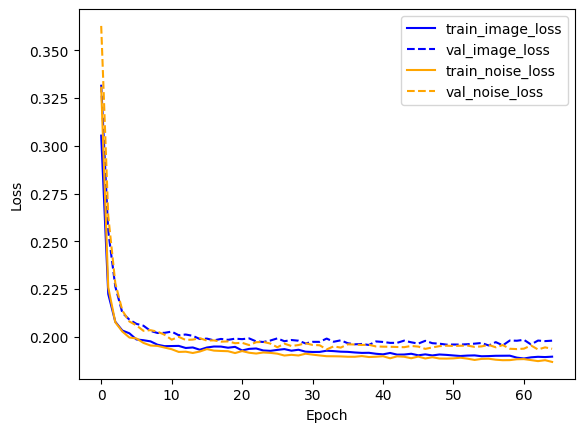

In [100]:
if TrainConfig.train:
    log = pd.read_csv(log_path)

    train_image_loss = log["image_loss"]
    train_noise_loss = log["noise_loss"]
    val_image_loss = log["val_image_loss"]
    val_noise_loss = log["val_noise_loss"]

    plt.plot(train_image_loss, label="train_image_loss", color="blue")
    plt.plot(val_image_loss, label="val_image_loss", linestyle="--", color="blue")
    plt.plot(train_noise_loss, label="train_noise_loss", color="orange")
    plt.plot(val_noise_loss, label="val_noise_loss", linestyle="--", color="orange")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


## Inference

In [15]:
print("Load best weight...")
model.load_weights(ckpt_path)

if (DirPath.output / "inference").exists():
    shutil.rmtree(DirPath.output / "inference")

(DirPath.output / "inference").mkdir(parents=True)

test_epoch = len(df_test) // TrainConfig.batch_size + 1
step = 0
for id, text_embeddings in tqdm(
    dataset_test, total=test_epoch, desc="Generate image", colour="green"
):
    step += 1
    if step > test_epoch:
        break

    generated_images = model.generate(
        num_images=TrainConfig.batch_size,
        text_embs=text_embeddings,
        un_text_embs=unconditional_test_embeddings,
        diffusion_steps=TrainConfig.plot_diffusion_steps,
        cfg_scale=TrainConfig.cfg_scale,
    )

    for i, img in enumerate(generated_images):
        plt.imsave(
            DirPath.output / f"inference/inference_{id[i]:04d}.jpg",
            img.numpy(),
            vmin=0.0,
            vmax=1.0,
        )


Load best weight...


Generate image: 100%|██████████| 18/18 [06:13<00:00, 20.73s/it]


In [16]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

os.chdir("./evaluation")
os.system("python inception_score.py ../output/inference ../output/score.csv 39")
os.chdir("..")

df_score = pd.read_csv("./output/score.csv")
print(f"Score: {np.mean(df_score['score']):.4f} ± {np.std(df_score['score']):.4f}")


1 Physical GPUs, 1 Logical GPUs
--------------Evaluation Success-----------------
Score: 0.4668 ± 0.1736
